# Testing Machine Learning Techniques on the Sandbox Data

This is the second notebook, where machine learning techniques are applied to the data processed in Starbucks_Sandbox.ipynb.

The main motive here for applying machine learning is:

- The bins are discrete and not continuous.  Machine learning allows us to treat continuous parameters as continuous.


In [1]:
import pandas as pd
import numpy as np
import math
import json
import progressbar
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
sns.set_context('talk')
import progressbar

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import tensorflow as tf

%matplotlib inline

palette = sns.color_palette()

In [2]:
# load dataframes from main notebook
offers_rev = pd.read_pickle('./data/offers_rev.pkl')
profile_extended = pd.read_pickle('./data/profile_extended.pkl')
portfolio_extended = pd.read_pickle('./data/portfolio_extended.pkl')
portfolio = pd.read_pickle('./data/portfolio.pkl')

In [3]:
order_nickname = (offers_rev.groupby(by='nickname')['ten_day_profit_minus_reward']
                      .mean()
                      .sort_values(ascending=False)
                      .index
                      .tolist())

order_offer_type = ['none', 'bogo', 'discount','informational']

In [4]:
# use a subset of the data for machine learning
offers_rev_subset = offers_rev[(offers_rev.time_received < 500)].loc[:,
    ['gender', 'age', 'days_of_membership', 'income', 'anonymous',
     'completed', 'ten_day_profit_minus_reward', 'offer_id', 'person']]
offers_rev_subset.head()

,gender,age,days_of_membership,income,anonymous,completed,ten_day_profit_minus_reward,offer_id,person
0,None,118,529,NaN,True,False,0.0000,no_offer,68be06ca386d4c31939f3a4f0e3dd783
1,F,55,376,112000.0,False,False,13.4475,no_offer,0610b486422d4921ae7d2bf64640c50b
2,None,118,14,NaN,True,False,0.3350,no_offer,38fe809add3b4fcf9315a9694bb96ff5
3,F,75,443,100000.0,False,True,16.7650,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef
4,None,118,356,NaN,True,False,0.2725,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43


In [5]:
def train_test_split(df, train_frac):
    """
    Splits the dataframe into training, validation and testing sets
    
    INPUT:
    df: (dataframe) - a pandas dataframe to be split
    train_frac: (float) - fraction of the dataset for training
    
    RETURNS:
    (train_df, test_df) - tuple of pandas dataframes
    """

    shuffled = df.sample(frac=1)
    train_end_index = round(df.shape[0] * train_frac)
    
    train_df = shuffled.iloc[0:train_end_index, :]
    test_df = shuffled.iloc[train_end_index:,:]
    
    return (train_df, test_df)

In [6]:
# split test dataset off at the beginning
# training data and validation data will be subsetted from the training data
# testing data will be subsetted from the testing data

train_df, test_df = train_test_split(offers_rev_subset, 0.8)

In [7]:
# fit scalers to the training data
scalers = {'days_of_membership': None, 'age': None, 'income': None}

for column in scalers.keys():
    scalers[column] = StandardScaler().fit(train_df[column].values.reshape(-1,1))

In [8]:
def prepare_tensorflow_dataset(df, scalers, categorical_variables, target, feature_names=None):
    """
    A pipeline for preparing the offers dataframes for tensorflow.
    
    INPUT:
    df: (dataframe) - a dataframe with continuous variables to be scaled
    scalers: (dict) containing sklearn scaler objects, keys are column names
                    implicitly sets the list of continuous variables
    categorical_variables: (list): column names to pass to pd.get_dummies
    target: (str): the column containing the target values
    feature_names: (list) feature names will be appended to this list.  not returned.
    
    RETURNS:
    dataset: (tf.data.Dataset): a tensorflow dataset
    """
    
    # copy the dataframe in function scope and limit to relevant columns
    cols = list(scalers.keys()) + categorical_variables + [target]
    local_df = df[cols].copy()
    # scale the continuous variables
    for column in scalers.keys():
        local_df[column] = scalers[column].transform(local_df[column].values.reshape(-1,1))
        
    dummied = pd.get_dummies(local_df, columns=categorical_variables, drop_first=False)
    
    if feature_names is not None:
        feature_names += dummied.columns[dummied.columns != target].tolist()
    
    X = dummied.loc[:,dummied.columns != target].values
    
    # tensorflow cannot accept boolean values so
    #   - if dtype is float, pass as is
    #   - else, convert to int
    if dummied.dtypes[target] == 'float64':
        y = dummied[target].values.reshape(-1,1)
    else:
        y = dummied[target].values.reshape(-1,1).astype(int)
        
        
    return tf.data.Dataset.from_tensor_slices((X, y))

# Implementation - Estimate 10-Day Profit-Revenue

Model needs to estimate the 10-day profit minus revenue that each offer would bring in.

In [9]:
feature_names_rev = []
# prepare training and validation sets from train data
df_rev = train_df[~train_df.anonymous]
splits_rev = train_test_split(df_rev, 0.8)
train_rev, valid_rev = [prepare_tensorflow_dataset(data,
                                                     scalers,
                                                     ['gender', 'offer_id'],
                                                     'ten_day_profit_minus_reward', []).batch(32)
                        for data in splits_rev]

# prepare test data from test data
test_revenue = test_df[~test_df.anonymous]
test_rev = prepare_tensorflow_dataset(test_revenue,
                                      scalers,
                                      ['gender','offer_id'],
                                      'ten_day_profit_minus_reward', feature_names_rev).batch(32)

In [10]:
tf.keras.backend.clear_session()

#Add Early Stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2)

#Add model checkpoint callback
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='./models/revenue_best.h5', 
                                                               monitor='val_loss', save_best_only=True,
                                                              save_freq='epoch', mode='auto')

# Model Architecture
model_rev = tf.keras.Sequential([tf.keras.layers.Dense(32, activation='relu'),
                                 tf.keras.layers.Dense(16, activation='relu'),
                                        tf.keras.layers.Dense(1)])

# Compile Model
model_rev.compile(optimizer='adam', loss='MSE')

# Fit model
model_rev.fit(train_rev, epochs=60, validation_data=valid_rev,
                     callbacks=[early_stop, model_checkpoint]);

# Load best model from training
model_rev.load_weights('./models/revenue_best.h5')

Epoch 1/60
1186/1186 [==============================] - 2s 1ms/step - loss: 62.4731 - val_loss: 49.9377
Epoch 2/60
1186/1186 [==============================] - 1s 796us/step - loss: 50.4849 - val_loss: 49.4101
Epoch 3/60
1186/1186 [==============================] - 1s 869us/step - loss: 50.0404 - val_loss: 49.1521
Epoch 4/60
1186/1186 [==============================] - 1s 908us/step - loss: 49.8136 - val_loss: 49.0135
Epoch 5/60
1186/1186 [==============================] - 1s 836us/step - loss: 49.6743 - val_loss: 48.9354
Epoch 6/60
1186/1186 [==============================] - 1s 799us/step - loss: 49.5778 - val_loss: 48.8738
Epoch 7/60
1186/1186 [==============================] - 1s 790us/step - loss: 49.4986 - val_loss: 48.8268
Epoch 8/60
1186/1186 [==============================] - 1s 811us/step - loss: 49.4307 - val_loss: 48.8040
Epoch 9/60
1186/1186 [==============================] - 1s 791us/step - loss: 49.3774 - val_loss: 48.7778
Epoch 10/60
1186/1186 [=========================

# Refinement

In [11]:
# try two hidden layers
tf.keras.backend.clear_session()

#Add Early Stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2)

#Add model checkpoint callback
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='./models/revenue_best.h5', 
                                                               monitor='val_loss', save_best_only=True,
                                                              save_freq='epoch', mode='auto')

# Model Architecture
model_rev = tf.keras.Sequential([tf.keras.layers.Dense(64, activation='relu'),
                                 tf.keras.layers.Dense(32, activation='relu'),
                                 tf.keras.layers.Dense(16, activation='relu'),
                                        tf.keras.layers.Dense(1)])

# Compile Model
model_rev.compile(optimizer='adam', loss='MSE')

# Fit model
model_rev.fit(train_rev, epochs=60, validation_data=valid_rev,
                     callbacks=[early_stop, model_checkpoint]);

# Load best model from training
model_rev.load_weights('./models/revenue_best.h5')

Epoch 1/60
1186/1186 [==============================] - 1s 846us/step - loss: 58.3475 - val_loss: 49.6553
Epoch 2/60
1186/1186 [==============================] - 1s 799us/step - loss: 50.0423 - val_loss: 49.3474
Epoch 3/60
1186/1186 [==============================] - 1s 787us/step - loss: 49.7597 - val_loss: 49.1924
Epoch 4/60
1186/1186 [==============================] - 1s 796us/step - loss: 49.5871 - val_loss: 49.0581
Epoch 5/60
1186/1186 [==============================] - 1s 805us/step - loss: 49.4596 - val_loss: 48.9697
Epoch 6/60
1186/1186 [==============================] - 1s 820us/step - loss: 49.3607 - val_loss: 48.9570
Epoch 7/60
1186/1186 [==============================] - 1s 796us/step - loss: 49.2880 - val_loss: 48.9122
Epoch 8/60
1186/1186 [==============================] - 1s 810us/step - loss: 49.2257 - val_loss: 48.8999
Epoch 9/60
1186/1186 [==============================] - 1s 818us/step - loss: 49.1687 - val_loss: 48.9115
Epoch 10/60
1186/1186 [=======================

In [12]:
# try single hidden layer with fewer nodes

tf.keras.backend.clear_session()
#Add Early Stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2)

#Add model checkpoint callback
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='./models/revenue_best.h5', 
                                                               monitor='val_loss', save_best_only=True,
                                                              save_freq='epoch', mode='auto')

# Model Architecture
model_rev = tf.keras.Sequential([tf.keras.layers.Dense(16, activation='relu'),
                                 tf.keras.layers.Dense(8, activation='relu'),
                                        tf.keras.layers.Dense(1)])

# Compile Model
model_rev.compile(optimizer='adam', loss='MSE')

# Fit model
model_rev.fit(train_rev, epochs=60, validation_data=valid_rev,
                     callbacks=[early_stop, model_checkpoint]);

# Load best model from training
model_rev.load_weights('./models/revenue_best.h5')

Epoch 1/60
1186/1186 [==============================] - 1s 789us/step - loss: 66.4232 - val_loss: 51.2146
Epoch 2/60
1186/1186 [==============================] - 1s 742us/step - loss: 51.4740 - val_loss: 49.7088
Epoch 3/60
1186/1186 [==============================] - 1s 745us/step - loss: 50.4363 - val_loss: 49.4310
Epoch 4/60
1186/1186 [==============================] - 1s 736us/step - loss: 50.1397 - val_loss: 49.2696
Epoch 5/60
1186/1186 [==============================] - 1s 741us/step - loss: 49.9311 - val_loss: 49.1661
Epoch 6/60
1186/1186 [==============================] - 1s 764us/step - loss: 49.7721 - val_loss: 49.0916
Epoch 7/60
1186/1186 [==============================] - 1s 756us/step - loss: 49.6592 - val_loss: 49.0354
Epoch 8/60
1186/1186 [==============================] - 1s 766us/step - loss: 49.5727 - val_loss: 49.0111
Epoch 9/60
1186/1186 [==============================] - 1s 750us/step - loss: 49.5037 - val_loss: 48.9781
Epoch 10/60
1186/1186 [=======================

In [13]:
# add a feature -  bring in median transaction amount from profiles
# it is reasonable that stuckbars would know this from prior experience with the customers

offers_rev = pd.merge(offers_rev,
         profile_extended[['id', 'median_transaction_no_outliers']],
         left_on='person', right_on='id', how='left').drop(columns='id')
offers_rev['median_transaction_no_outliers'] = offers_rev['median_transaction_no_outliers'].fillna(0)

In [14]:
# re-create the subsets, scalers and train/test dataframes with the new feature
offers_rev_subset = offers_rev[(offers_rev.time_received < 500)].loc[:,
    ['gender', 'age', 'days_of_membership', 'income', 'anonymous',
     'completed', 'ten_day_profit_minus_reward', 'offer_id', 'person',
    'median_transaction_no_outliers']]

train_df, test_df = train_test_split(offers_rev_subset, 0.8)

# fit scalers to the training data
scalers = {'days_of_membership': None, 'age': None, 'income': None, 'median_transaction_no_outliers': None}

for column in scalers.keys():
    scalers[column] = StandardScaler().fit(train_df[column].values.reshape(-1,1))

In [15]:
# prepare tensorflow dataset with the new feature

feature_names_rev = []
# prepare training and validation sets from train data
df_rev = train_df[~train_df.anonymous]
splits_rev = train_test_split(df_rev, 0.8)
train_rev, valid_rev = [prepare_tensorflow_dataset(data,
                                                     scalers,
                                                     ['gender', 'offer_id'],
                                                     'ten_day_profit_minus_reward', []).batch(32)
                        for data in splits_rev]

# prepare test data from test data
test_revenue = test_df[~test_df.anonymous]
test_rev = prepare_tensorflow_dataset(test_revenue,
                                      scalers,
                                      ['gender','offer_id'],
                                      'ten_day_profit_minus_reward', feature_names_rev).batch(32)

In [16]:
# the performance of previous models was about the same, take the first one (best on current run)

tf.keras.backend.clear_session()

#Add Early Stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2)

#Add model checkpoint callback
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='./models/revenue_best.h5', 
                                                               monitor='val_loss', save_best_only=True,
                                                              save_freq='epoch', mode='auto')

# Model Architecture
model_rev = tf.keras.Sequential([tf.keras.layers.Dense(32, activation='relu'),
                                 tf.keras.layers.Dense(16, activation='relu'),
                                        tf.keras.layers.Dense(1)])

# Compile Model
model_rev.compile(optimizer='adam', loss='MSE')

# Fit model
model_rev.fit(train_rev, epochs=60, validation_data=valid_rev,
                     callbacks=[early_stop, model_checkpoint]);

# Load best model from training
model_rev.load_weights('./models/revenue_best.h5')

Epoch 1/60
1186/1186 [==============================] - 1s 800us/step - loss: 56.2247 - val_loss: 48.1880
Epoch 2/60
1186/1186 [==============================] - 1s 749us/step - loss: 46.5082 - val_loss: 47.5584
Epoch 3/60
1186/1186 [==============================] - 1s 757us/step - loss: 45.9098 - val_loss: 47.3309
Epoch 4/60
1186/1186 [==============================] - 1s 767us/step - loss: 45.6434 - val_loss: 47.1994
Epoch 5/60
1186/1186 [==============================] - 1s 776us/step - loss: 45.4325 - val_loss: 47.1334
Epoch 6/60
1186/1186 [==============================] - 1s 769us/step - loss: 45.2974 - val_loss: 47.0595
Epoch 7/60
1186/1186 [==============================] - 1s 771us/step - loss: 45.1799 - val_loss: 47.0429
Epoch 8/60
1186/1186 [==============================] - 1s 761us/step - loss: 45.0551 - val_loss: 47.0003
Epoch 9/60
1186/1186 [==============================] - 1s 763us/step - loss: 44.9429 - val_loss: 46.9947
Epoch 10/60
1186/1186 [=======================

In [17]:
# tf.data.Dataset is an iterable, need to get a full list of predictions and labels from the test data
# define function to help

def predict_test_data(model, test_batches, feature_names, scalers = {}, activation=tf.math.sigmoid):
    """
    A function to return a pandas dataframe of predicted vs actual labels given a model and testing dataset.
    
    INPUT:
    model (tf.keras.model): the trained model
    test_batches (tf.data.Dataset): a batched dataset containing the testing data
    feature_names (list): an ordered list of the feature names matching the features in test_batches
    scalers(optional): (dict) a dictionary of scaler objects to reverse-transform the features
    activation(optional): (function) activation function to be applied to the prediction results
    
    Returns:
    df (pd.DataFrame): a pandas dataframe containing predicted and actual values with features
    """
    
    labels = []
    predictions = []
    features = []
    for batch_features, batch_labels in test_batches:
        preds = model.predict(batch_features).reshape(-1)
        if activation is not None:
            preds = activation(preds)
        predictions.append(preds)
        labels.append(batch_labels)
        features.append(batch_features)
        
    df_results = pd.DataFrame(data={'labels': np.concatenate(labels).reshape(-1),
                  'predictions': np.concatenate(predictions)})
    
    df_features = pd.DataFrame(data=np.concatenate(features), columns=feature_names)
    
    for column in scalers.keys():
        df_features[column] = scalers[column].inverse_transform(df_features[column])
    
    return pd.concat([df_features, df_results], axis=1)

In [18]:
test_rev_result = predict_test_data(model_rev, test_rev,
                                        feature_names_rev,
                                     scalers, activation=None)

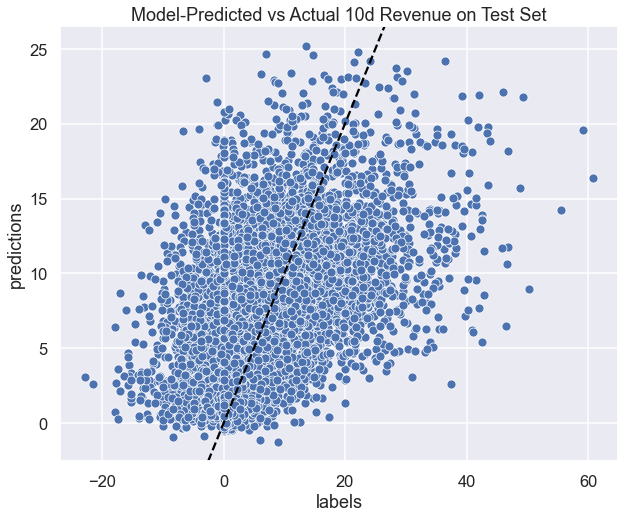

In [19]:
# this performance doesn't look very good - there is a big cloud
# but do have to keep in mind our competition is to just guess the average
# for each offer

f, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(data=test_rev_result, x='labels', y='predictions', ax=ax)
ax.axline([0, 0], [1, 1], color='black', ls='--')
ax.set(title='Model-Predicted vs Actual 10d Revenue on Test Set');

In [20]:
# evaluate MSE on test set
print("MSE of Model on Test Set:", model_rev.evaluate(test_rev))

372/372 [==============================] - 0s 482us/step - loss: 46.6910
MSE of Model on Test Set: 46.69098663330078


In [21]:
offers_rev.columns

Index(['offer_presentation_id', 'gender', 'age', 'person', 'became_member_on',
       'income', 'days_of_membership', 'anonymous', 'time_received',
       'offer_id', 'viewed', 'time_viewed', 'completed', 'time_completed',
       'completed_not_viewed', 'viewed_after_completed', 'ten_day_revenue',
       'ten_day_rewards', 'duration_revenue', 'duration_rewards', 'reward',
       'difficulty', 'duration', 'offer_type', 'nickname', 'channel_web',
       'channel_email', 'channel_mobile', 'channel_social', 'ten_day_profit',
       'ten_day_profit_minus_reward', 'duration_profit',
       'duration_profit_minus_reward', 'daily_revenue', 'daily_profit',
       'daily_profit_minus_reward', 'median_transaction_no_outliers'],
      dtype='object')

In [22]:
# evaluate MSE for just guessing the average for each offer
# so the model is doing much better than just guessing the average
avg_profit_by_offer = offers_rev.groupby(by='offer_id')['ten_day_profit_minus_reward'].mean().rename('predicted')

test_revenue_guess = pd.merge(test_revenue,
                              avg_profit_by_offer,
                              left_on='offer_id', right_index=True, how='left')

print("MSE of Using Overall Average for Each Offer:", 
tf.keras.metrics.mean_squared_error(test_revenue_guess.ten_day_profit_minus_reward,
                                    test_revenue_guess.predicted).numpy())

MSE of Using Overall Average for Each Offer: 59.82812105731269


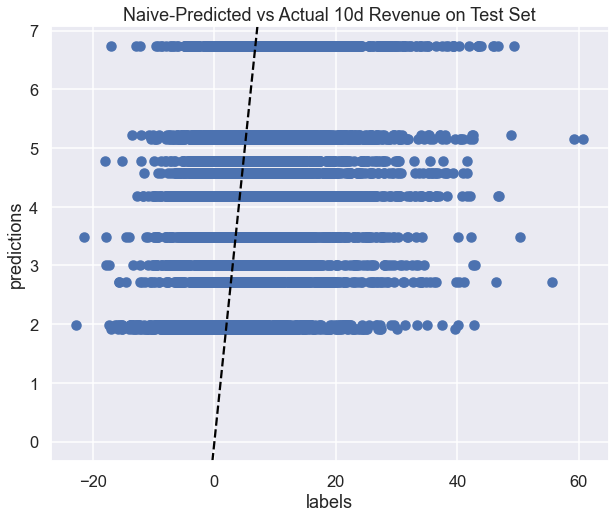

In [23]:
# plot predicted/actual for naive prediction
f, ax = plt.subplots(figsize=(10,8))
ax.scatter(test_revenue_guess.ten_day_profit_minus_reward, test_revenue_guess.predicted)
ax.axline([0, 0], [1, 1], color='black', ls='--')
ax.set(xlabel='labels', ylabel='predictions', title='Naive-Predicted vs Actual 10d Revenue on Test Set');

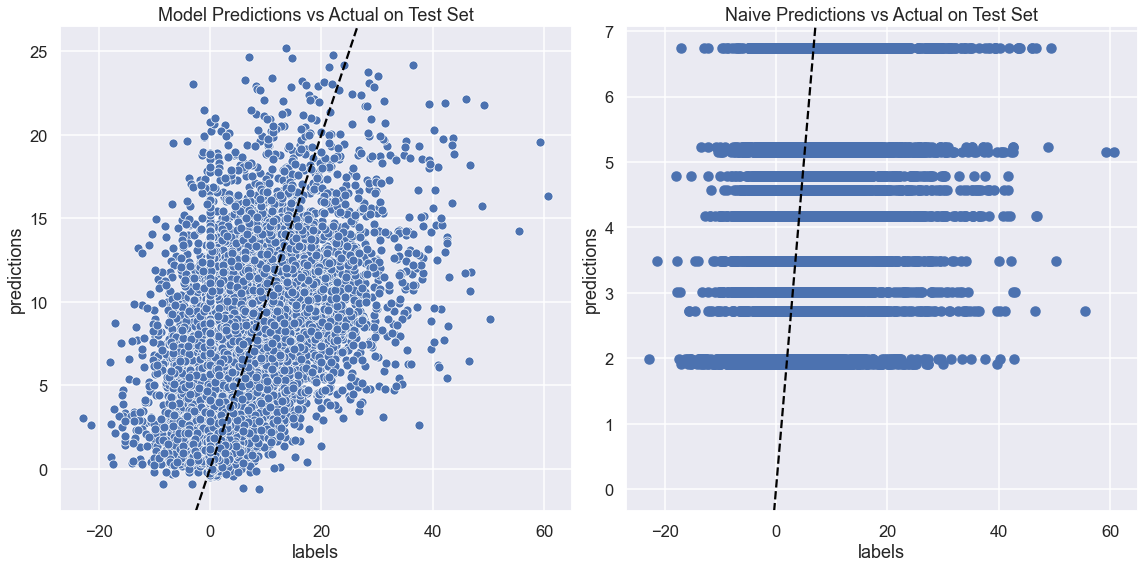

In [24]:
f, axs = plt.subplots(ncols=2, figsize=(16,8))
axs= axs.flatten()
sns.scatterplot(data=test_rev_result, x='labels', y='predictions', ax=axs[0])
axs[1].scatter(test_revenue_guess.ten_day_profit_minus_reward, test_revenue_guess.predicted)
axs[0].axline([0, 0], [1, 1], color='black', ls='--')
axs[1].axline([0, 0], [1, 1], color='black', ls='--')
axs[1].set(xlabel='labels', ylabel='predictions', title='Naive Predictions vs Actual on Test Set')
axs[0].set(title='Model Predictions vs Actual on Test Set')
plt.tight_layout();
plt.savefig('./images/Model_vs_Naive.png', dpi=600)

In [25]:
# ok so is the model doing better or worse on certain offers?

# bring predictions back into normal dataframe (not one-hot encoded)
test_rev_result = pd.concat([test_revenue.reset_index(), test_rev_result.reset_index()['predictions']], axis=1)
test_rev_result['predicted-actual'] = test_rev_result.predictions - test_rev_result.ten_day_profit_minus_reward
test_rev_result['squared_error'] = test_rev_result['predicted-actual'] ** 2
test_rev_result = pd.merge(test_rev_result, portfolio[['id', 'nickname', 'offer_type']],
                           left_on='offer_id', right_on='id', how='left')

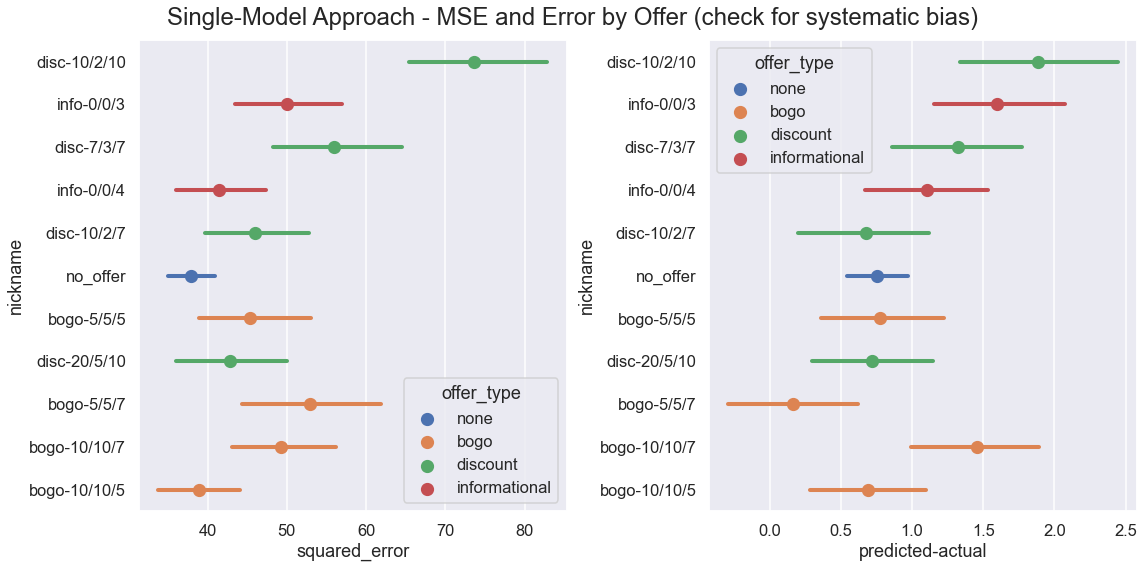

In [26]:
# plot predicted - actual for different offers to see if the model over/underpredicts for some
f, axs = plt.subplots(ncols=2, figsize=(16,8))
axs = axs.flatten()
sns.pointplot(data=test_rev_result, x='squared_error', y='nickname', hue='offer_type', 
              order=order_nickname, hue_order=order_offer_type, ax=axs[0], join=False)
sns.pointplot(data=test_rev_result, x='predicted-actual', y='nickname', hue='offer_type',
              order=order_nickname, hue_order=order_offer_type, ax=axs[1], join=False)
f.suptitle('Single-Model Approach - MSE and Error by Offer (check for systematic bias)', fontsize=24)
plt.tight_layout();
plt.savefig('./images/single_model_by_offer.png', dpi=600)

In [27]:
# the model is underpredicting a bit for some offers and overpredicting for others.
# this performance is likely usable (note that error bars overlap significantly)
# but let's try to do better

# try to fit a model for each offer

dict_models = {}

for offer in progressbar.progressbar(train_df.offer_id.unique().tolist()):
    # generate a tensorflow dataset
    local_df = df_rev[df_rev.offer_id==offer]
    splits_local = train_test_split(local_df, 0.8)
    local_train, local_valid = [prepare_tensorflow_dataset(data,
                                                     scalers,
                                                     ['gender'],
                                                     'ten_day_profit_minus_reward', []).batch(32)
                                for data in splits_local]
    # build generate everything necessary to build a model
    tf.keras.backend.clear_session()
    tf.autograph.set_verbosity(0)
    #Add Early Stopping callback
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2)

    #Add model checkpoint callback
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='./models/rev_'+offer+ '.h5', 
                                                                   monitor='val_loss', save_best_only=True,
                                                                  save_freq='epoch', mode='auto')

    # Model Architecture
    dict_models[offer] = tf.keras.Sequential([tf.keras.layers.Dense(32, activation='relu'), 
                                 tf.keras.layers.Dense(16, activation='relu'),
                                 tf.keras.layers.Dense(1)])

    # Compile Model
    dict_models[offer].compile(optimizer='adam', loss='MSE')

    # Fit model
    dict_models[offer].fit(local_train, epochs=60, validation_data=local_valid,
                         callbacks=[early_stop, model_checkpoint], verbose=0);
    
    dict_models[offer].load_weights('./models/rev_'+offer+ '.h5')

100% (11 of 11) |########################| Elapsed Time: 0:00:45 Time:  0:00:45


In [28]:
# make predictions on the test set
rev_results = []

# iterate offers
for offer in train_df.offer_id.unique().tolist():
    # prep data for that specific offer
    name = []
    local = test_revenue[test_revenue.offer_id==offer]
    tf_data = prepare_tensorflow_dataset(local, scalers, ['gender'], 'ten_day_profit_minus_reward', name).batch(32)
    # generate predictions dataframe and add to list
    result = predict_test_data(dict_models[offer], tf_data, name, scalers, activation=None)
    result['offer_id'] = offer
    rev_results.append(result)

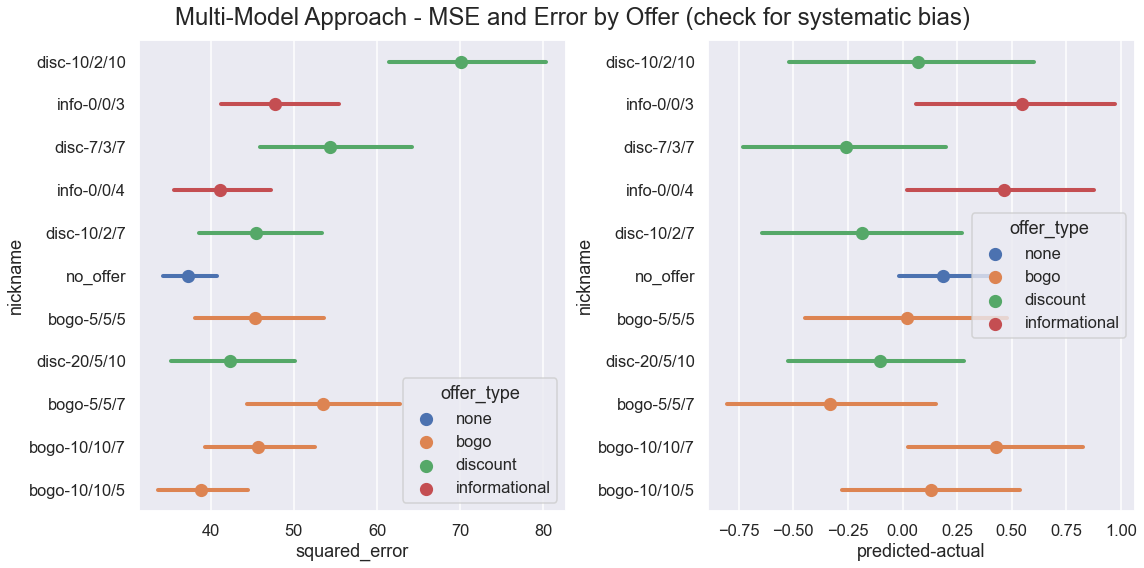

In [29]:
# plot results for test set
multi_model = pd.concat(rev_results, axis=0)
multi_model['predicted-actual'] = multi_model.predictions - multi_model.labels
multi_model['squared_error'] = multi_model['predicted-actual'] ** 2
multi_model = pd.merge(multi_model, portfolio[['id', 'nickname', 'offer_type']],
               left_on='offer_id', right_on='id', how='left')
f, axs = plt.subplots(ncols=2, figsize=(16,8))
axs = axs.flatten()
sns.pointplot(data=multi_model, x='squared_error', y='nickname', hue='offer_type',
              order=order_nickname, hue_order=order_offer_type, join=False, ax=axs[0]);
sns.pointplot(data=multi_model, x='predicted-actual', y='nickname', hue='offer_type',
              order=order_nickname, hue_order=order_offer_type, join=False, ax=axs[1])
f.suptitle('Multi-Model Approach - MSE and Error by Offer (check for systematic bias)', fontsize=24)
plt.tight_layout();
plt.savefig('./images/multi_model_by_offer.png', dpi=600)

In [30]:
print('MSE of Multi-Model Approach on Test Set:',
     tf.keras.metrics.mean_squared_error(multi_model.labels, multi_model.predictions).numpy())
print('MSE of Single-Model on Test Set:', model_rev.evaluate(test_rev, verbose=0))

MSE of Multi-Model Approach on Test Set: 45.623688
MSE of Single-Model on Test Set: 46.69098663330078


## Model Performance

So the model does do significantly better at predicting ten day profit than naively taking the average for any given offer.  The model size

Unfortunately, the model is slightly biased in how it predicts: it overpredicts for some offers and underpredicts for others.

An alternative approach of training a separate model for each offer was also tested, but the over/under bias was unaffected and the overall test set MSE was slightly worse.  As a result, the original model using offer id as an input will be used.

In [31]:
# generate all combinations of all customers and all offers
profile_reps = []
for offer_id in portfolio.id:
    tmp = profile_extended[~profile_extended.anonymous].copy()
    tmp['offer_id'] = offer_id
    tmp['ten_day_profit_minus_reward'] = 0
    profile_reps.append(tmp)

# bring the combinations together, fill NAs for users who made zero transactions
all_customers_all_offers = pd.concat(profile_reps, axis=0)
all_customers_all_offers['median_transaction_no_outliers'] = all_customers_all_offers.median_transaction.fillna(0)
# reset index to have a robust index
all_customers_all_offers = all_customers_all_offers.reset_index().drop(columns='index')

In [32]:
# prepare data to feed to model and make predictions
all_customers_tf = prepare_tensorflow_dataset(all_customers_all_offers, 
                                              scalers,
                                              ['gender', 'offer_id'],
                                              'ten_day_profit_minus_reward', []).batch(32)

all_customers_all_offers['predicted'] = model_rev.predict(all_customers_tf)

In [33]:
# determine which offer was predicted best for each customer
best_indices = all_customers_all_offers.groupby('id').predicted.idxmax()
best_offers = all_customers_all_offers.loc[best_indices,:]
best_offers = best_offers.join(portfolio[['id', 'nickname', 'offer_type']].set_index('id'),
                                                      on='offer_id', how='left')

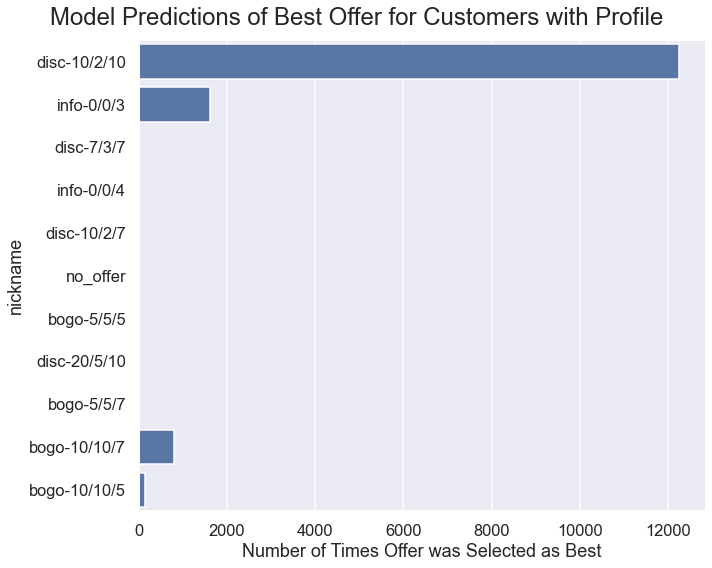

In [34]:
# display results of predictions overall
f, ax = plt.subplots(figsize=(10,8))
sns.countplot(data=best_offers, y='nickname', order=order_nickname, color=sns.color_palette()[0])
ax.set(xlabel='Number of Times Offer was Selected as Best')
f.suptitle('Model Predictions of Best Offer for Customers with Profile', fontsize=24)
plt.tight_layout();
plt.savefig('./images/model_recommendations.png', dpi=600)

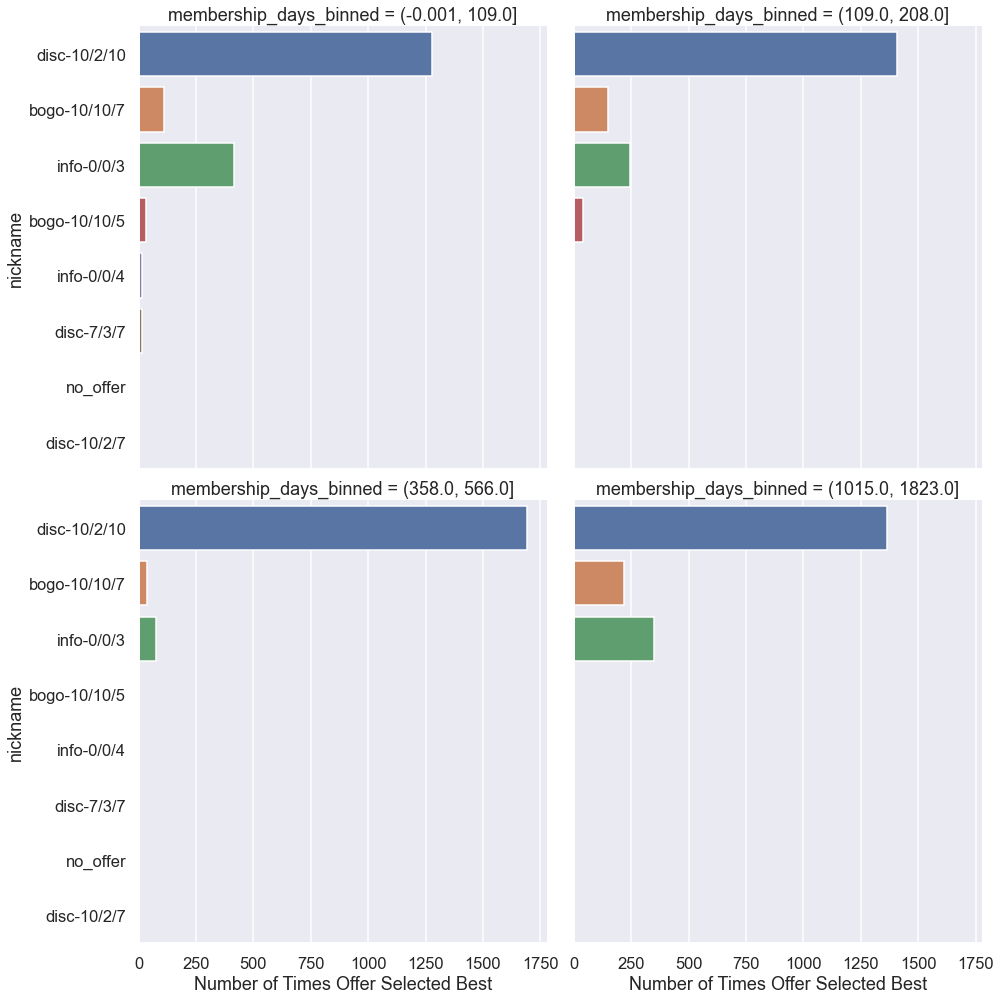

In [35]:
# display results of predictions for membership tenure subsets used in the EDA

selected_bins = ['(-0.001, 109.0]', '(109.0, 208.0]', '(358.0, 566.0]', '(1015.0, 1823.0]']

order_bins = [x for x in best_offers.membership_days_binned.unique().categories if str(x) in selected_bins]

g = sns.catplot(data=best_offers[best_offers.membership_days_binned.astype(str).isin(selected_bins)], 
            y='nickname', col='membership_days_binned', col_wrap=2, col_order=order_bins, kind='count', height=7)
g.set_axis_labels('Number of Times Offer Selected Best', 'nickname');
plt.tight_layout();
g.savefig('./images/model_recommendations_membership_days.png')

# What is the model recommending?

The model is generally recommending the top offer overall, which makes sense.  The recommendations across membership tenure groups also match the observations from EDA - the nearer-term members do better with informational, bogo and no offer than most.  At the higher membership tenures, the model is also finding some opportunities to present informational offers and bogo offers as well, which is interesting.

In [36]:
all_customers_tf

<BatchDataset shapes: ((None, 18), (None, 1)), types: (tf.float64, tf.int64)>